## POS-Tagging, HMMs & Viterbi

We have build own HMM-based POS tagger and implement the Viterbi algorithm using the Penn Treebank training corpus. The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. 

We have to build model to tag unknown words using modified Viterbi Algorithm to increase accuracy.


No | Algorithm | POS Tagging Accuracy
-|---------------------|----------------|
1|Viterbi (Basic) | 0.90 
2|Viterbi Laplace smoothened | 0.927
3|<b><font color='#00cccc'>Viterbi with RegExp for morphological cues</font></b> | <b><font color='#00FF00'>0.947</font></b>
4|Viterbi using most known tags for unknown | 0.928
5|Viterbi using only transistion prob in unknown words | 0.928

We found Modified Viterbi with Regular expression on Morphological cues model to be the best model with accuracy of 94.7%.

## 1. Exploring Treebank Tagged Corpus

In [232]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [233]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [234]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [235]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Tony', 'NOUN'), ('Lama', 'NOUN'), ('Co.', 'NOUN'), ('said', 'VERB'), ('that', 'ADP'), ('Equus', 'NOUN'), ('Investment', 'NOUN'), ('II', 'NOUN'), ('Limited', 'NOUN'), ('Partnership', 'NOUN'), ('has', 'VERB'), ('proposed', 'VERB'), ('*-1', 'X'), ('changing', 'VERB'), ('the', 'DET'), ('offer', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ('to', 'PRT'), ('$', '.'), ('13.65', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('cash', 'NOUN'), ('and', 'CONJ'), ('stock', 'NOUN'), ('from', 'ADP'), ('an', 'DET'), ('all-cash', 'ADJ'), ('transaction', 'NOUN'), ('.', '.')], [('These', 'DET'), ('nations', 'NOUN'), ("'", 'PRT'), ('internal', 'ADJ'), ('decisions', 'NOUN'), ('``', '.'), ('will', 'VERB'), ('be', 'VERB'), ('made', 'VERB'), ('*-3', 'X'), ('in', 'ADP'), ('a', 'DET'), ('way', 'NOUN'), ('0', 'X'), ('*', 'X'), ('not', 'ADV'), ('to', 'PRT'), ('offend', 'VERB'), ('their', 'PRON'), ('largest', 'ADJ'), ('aid', 'NOUN'), ('donor', 'NOUN'), (',', '.'), ('largest', 'ADJ'), ('private

In [236]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95752

In [237]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Tony',
 'Lama',
 'Co.',
 'said',
 'that',
 'Equus',
 'Investment',
 'II',
 'Limited',
 'Partnership']

In [238]:
# vocabulary
V = set(tokens)
print(len(V))

12050


In [239]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [240]:
print(T)

{'ADJ', 'PRON', 'ADP', 'NUM', 'DET', 'PRT', 'X', 'ADV', 'CONJ', 'NOUN', '.', 'VERB'}


## 2. HMM(Hidden Markov Model) - POS Tagging Algorithm

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'ensure'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [241]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [242]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [243]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(28, 6063)
(0, 12948)
(0, 27423) 


 will
(0, 0)
(1, 27423)
(260, 12948)

 book
(7, 27423)
(1, 12948)


In [244]:
word_given_tag('Twitter','NOUN')

(0, 27423)

### Transition Probabilities

In [245]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [246]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('ADJ', 'NOUN'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'NOUN'))
print(t2_given_t1('PRT', 'PRT'))
print(t2_given_t1('VERB', 'NOUN'))

(4231, 6063)
(331, 27423)
(5297, 8301)
(1450, 12948)
(0, 27423)
(6, 3075)
(4024, 27423)


In [247]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('NOUN', '.'))


(1932, 11142)
(998, 11142)
(2467, 11142)
(2467, 11142)


In [248]:
t2_given_t1('VERB','DET')

(330, 8301)

In [249]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [250]:
tags_matrix

array([[6.63038120e-02, 6.59739424e-04, 7.73544461e-02, 2.01220512e-02,
        5.11298049e-03, 1.12155695e-02, 2.07817908e-02, 4.94804559e-03,
        1.76480282e-02, 6.97839379e-01, 6.56440705e-02, 1.23701142e-02],
       [7.19725788e-02, 7.99695309e-03, 2.32292451e-02, 7.23533891e-03,
        9.90098994e-03, 1.18050268e-02, 8.98705274e-02, 3.46534662e-02,
        5.33130253e-03, 2.13252097e-01, 3.92231531e-02, 4.85529333e-01],
       [1.06348865e-01, 6.94741309e-02, 1.74219757e-02, 6.09234720e-02,
        3.24497640e-01, 1.38948264e-03, 3.53783667e-02, 1.36810606e-02,
        8.55066290e-04, 3.21825564e-01, 3.97605821e-02, 8.44377931e-03],
       [3.27918157e-02, 1.50421180e-03, 3.61010842e-02, 1.85619742e-01,
        3.00842361e-03, 2.64741275e-02, 2.14500606e-01, 3.00842361e-03,
        1.29362214e-02, 3.50782186e-01, 1.14921778e-01, 1.83513835e-02],
       [2.04192266e-01, 3.49355489e-03, 9.75786056e-03, 2.21660044e-02,
        5.54150110e-03, 2.40934824e-04, 4.52957489e-02, 1.26

In [251]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [252]:
tags_df

,ADJ,PRON,ADP,NUM,DET,PRT,X,ADV,CONJ,NOUN,.,VERB
ADJ,0.066304,0.000660,0.077354,0.020122,0.005113,0.011216,0.020782,0.004948,0.017648,0.697839,0.065644,0.012370
PRON,0.071973,0.007997,0.023229,0.007235,0.009901,0.011805,0.089871,0.034653,0.005331,0.213252,0.039223,0.485529
ADP,0.106349,0.069474,0.017422,0.060923,0.324498,0.001389,0.035378,0.013681,0.000855,0.321826,0.039761,0.008444
NUM,0.032792,0.001504,0.036101,0.185620,0.003008,0.026474,0.214501,0.003008,0.012936,0.350782,0.114922,0.018351
DET,0.204192,0.003494,0.009758,0.022166,0.005542,0.000241,0.045296,0.012649,0.000482,0.638116,0.018311,0.039754
PRT,0.085203,0.017561,0.020488,0.053984,0.100813,0.001951,0.013333,0.010407,0.002276,0.247480,0.042276,0.404228
X,0.016756,0.056750,0.144641,0.002845,0.054379,0.185425,0.074455,0.025767,0.009959,0.061176,0.163611,0.204236
ADV,0.128904,0.015947,0.118272,0.029568,0.069767,0.013953,0.022591,0.080399,0.006977,0.032226,0.133555,0.347841
CONJ,0.119555,0.059314,0.053753,0.038925,0.119555,0.004634,0.008804,0.053753,0.000463,0.347544,0.036145,0.157553
NOUN,0.012070,0.004741,0.176348,0.009518,0.013055,0.044051,0.029063,0.016738,0.042847,0.264194,0.240637,0.146738


In [253]:
tags_df.loc['.', :]

ADJ     0.044157
PRON    0.065967
ADP     0.090379
NUM     0.081673
DET     0.173398
PRT     0.002244
X       0.027733
ADV     0.052055
CONJ    0.057889
NOUN    0.221414
.       0.093430
VERB    0.089571
Name: ., dtype: float32

#### Heatmap of tags matrix
#### T(i, j) means P(tag j given tag i)

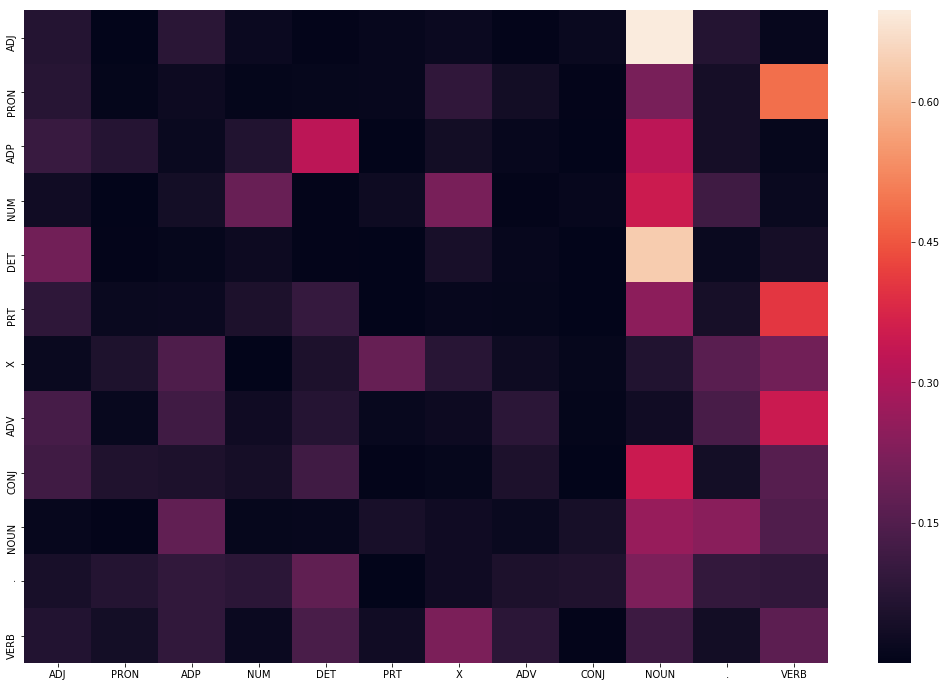

In [254]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


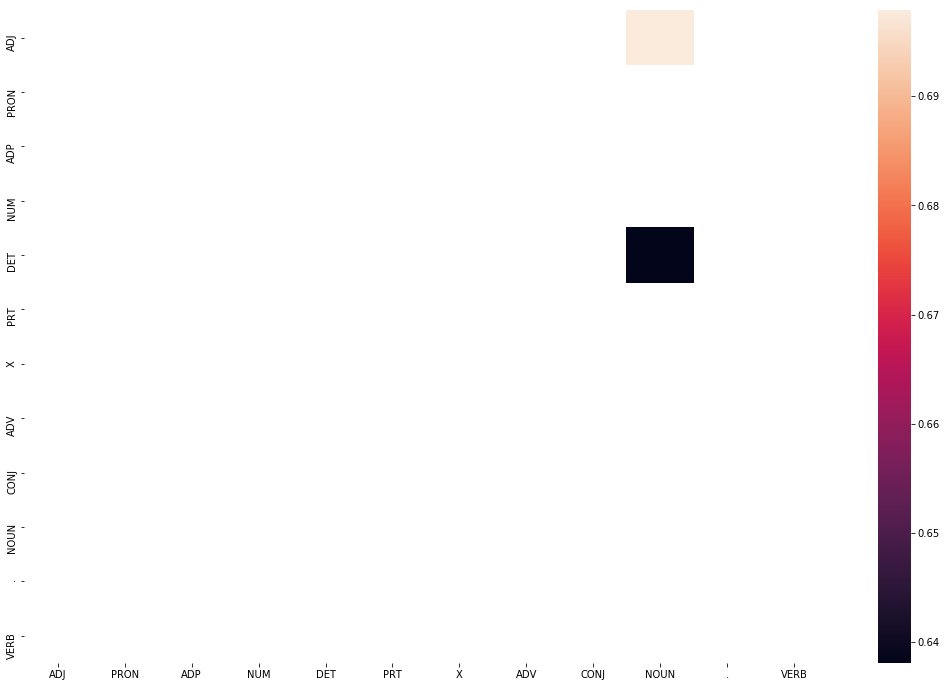

In [255]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Inference: We can see in the heatmap that ADJ follwed by NOUN has great correlation

## 3. Viterbi Algorithm 
    - Vanilla Viterbi
    - Viterbi Laplace Smoothened
    - Viterbi Manual using RegExp
    - Viterbi with unknown words given mostly used tag
    - Viterbi with only transistion probability incase of unknown words

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

### Vanilla Viterbi

In [256]:
# Viterbi Heuristic
def Viterbi_vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Vanilla Laplace smoothened

In [257]:
def Viterbi_smoothed(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = 0.000001+word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]+0.000001*len(T)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


### Viterbi with RegExp for unknown words 

In [258]:
def find_state(word):
    #punc=['"',"'",',','.','(',')','?','[',']',':',';']
    xc=['*']
    if re.search(r'.*(ing|ed|es|ould)$',word.lower()):
        return 'VERB'
    elif re.search(r'to$',str(word).lower()):
        return 'PRT'
    elif re.search(r'^-?[0-9]+(.[0-9]+)?\.*$',str(word).lower()):
        return 'NUM'
    elif '*' in word:
        return 'X'
    elif re.search(r'.*\'s$',word.lower()):
        return 'NOUN'
    elif re.search(r'.*ness$',word.lower()):
        return 'NOUN'
    elif re.search(r'(The|the|A|a|An|an)$',word):
        return 'ADP'
    elif re.search(r'.*able$',word.lower()):
        return 'ADJ'
    elif re.search(r'.*ly$',word.lower()):
        return 'ADV'
    elif re.search(r'(He|he|She|she|It|it|I|me|Me|You|you|His|his|Her|her|Its|its|my|Your|your|Yours|yours)$',word):
        return 'PRON'
    elif re.search(r'(on|On|at|At|since|Since|For|for|Ago|ago|before|Before|till|Till|until|Until|by|By|Beside|beside|under|Under|below|Below|over|Over|above|Above|across|Across|Through|through|Into|into|towards|Towards|onto|Onto|from|From)$',word):
        return 'ADP'
    elif re.search(r'',word):
        return 'NOUN'
    elif re.search(r'(\'|\"|\.|\(|\)|\?|\[|\]|\:|\;)+',word):
        return '.'
    else:        
        return 'NOUN'
    

    
def Viterbi_manual(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        if pmax==0.0:
            state_word=find_state(word)
            state.append(state_word)
            #print(word,':',state_word)
        else:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


### Viterbi for unknown words given mostly used tag

In [259]:
def Viterbi_common(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in tokens: 
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p=1
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        if pmax==0.0:
            state_word='NOUN'
            state.append(state_word)
            #print(word,':',state_word)
        else:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [260]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in tokens: 
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p=1
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [261]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

#random.seed(1234)

# choose random 5 sents
#rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
#test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base

[('Buying', 'VERB'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('most', 'ADJ'),
 ('part', 'NOUN'),
 ('carried', 'VERB'),
 ('over', 'PRT'),
 ('from', 'ADP'),
 ('the', 'DET'),
 ('previous', 'ADJ'),
 ('session', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('traders', 'NOUN'),
 ('apparently', 'ADV'),
 ('ignored', 'VERB'),
 ('reports', 'NOUN'),
 ('that', 'ADP'),
 ('a', 'DET'),
 ('Chilean', 'ADJ'),
 ('mine', 'ADJ'),
 ('strike', 'NOUN'),
 ('may', 'VERB'),
 ('have', 'VERB'),
 ('ended', 'VERB'),
 ('almost', 'ADV'),
 ('before', 'ADP'),
 ('it', 'PRON'),
 ('began', 'VERB'),
 (',', '.'),
 ('an', 'DET'),
 ('analyst', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('*T*-1', 'X'),
 ('.', '.'),
 ('``', '.'),
 ('But', 'CONJ'),
 ('now', 'ADV'),
 (',', '.'),
 ('there', 'DET'),
 ('seems', 'VERB'),
 ('*-2', 'X'),
 ('to', 'PRT'),
 ('be', 'VERB'),
 ('a', 'DET'),
 ('fairly', 'ADV'),
 ('systematic', 'ADJ'),
 ('effort', 'NOUN'),
 ('*', 'X'),
 ('to', 'PRT'),
 ('address', 'VERB'),
 ('the', 'DET'),
 ('problem', 'NOUN'),
 (',', '.

## 1. Testing our model on Vanilla Viterbi

In [262]:
# tagging the test sentences
start = time.time()
tagged_seq_vanilla = Viterbi_vanilla(test_tagged_words)
check = [i for i, j in zip(tagged_seq_vanilla, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_vanilla)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 797.6160218715668
Accuracy is : 0.9049553208773355


In [263]:
print('Vanilla Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Vanilla Viterbi-Incorrect tagged cases are:


[(('over', 'ADP'), ('over', 'PRT')),
 (('ignored', 'ADJ'), ('ignored', 'VERB')),
 (('mine', 'NOUN'), ('mine', 'ADJ')),
 (('Chuck', 'ADJ'), ('Chuck', 'NOUN')),
 (('Hurley', 'ADJ'), ('Hurley', 'NOUN')),
 (('communications', 'ADJ'), ('communications', 'NOUN')),
 (('THE', 'ADJ'), ('THE', 'DET')),
 (('WAR', 'ADJ'), ('WAR', 'NOUN')),
 (('OVER', 'ADJ'), ('OVER', 'ADP')),
 (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ')),
 (('SALARIES', 'ADJ'), ('SALARIES', 'NOUN')),
 (('delay', 'VERB'), ('delay', 'NOUN')),
 (('Unitholders', 'ADJ'), ('Unitholders', 'NOUN')),
 (('down', 'ADV'), ('down', 'PRT')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Pretax', 'ADJ'), ('Pretax', 'NOUN')),
 (('128', 'ADJ'), ('128', 'NUM')),
 (('133', 'ADJ'), ('133', 'NUM')),
 (('135', 'ADJ'), ('135', 'NUM')),
 (('388', 'ADJ'), ('388', 'NUM')),
 (('Constitutional', 'ADJ'), ('Constitutional', 'NOUN')),
 (('Convention', 'ADJ'), ('Convention', 'NOUN')),
 (('1787', 'ADJ'), ('1787', 'NUM')),
 (('up', 'PRT'), ('up', 'ADV')),
 (('56', 'ADJ'), ('5

## 2. Testing model on Viterbi Laplace smoothened

In [264]:
# tagging the test sentences
start = time.time()
tagged_seq_smooth = Viterbi_smoothed(test_tagged_words)

In [265]:
check = [i for i, j in zip(tagged_seq_smooth, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_smooth)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 772.9536218643188
Accuracy is : 0.9272948822095857


In [266]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_smooth, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('over', 'ADP'), ('over', 'PRT')),
 (('Chilean', 'NOUN'), ('Chilean', 'ADJ')),
 (('mine', 'NOUN'), ('mine', 'ADJ')),
 (('Chuck', 'VERB'), ('Chuck', 'NOUN')),
 (('Hurley', 'X'), ('Hurley', 'NOUN')),
 (('communications', 'DET'), ('communications', 'NOUN')),
 (('THE', 'NOUN'), ('THE', 'DET')),
 (('OVER', 'NOUN'), ('OVER', 'ADP')),
 (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ')),
 (('JUDICIAL', 'NOUN'), ('JUDICIAL', 'ADJ')),
 (('cents-a-unit', 'NOUN'), ('cents-a-unit', 'ADJ')),
 (('down', 'ADV'), ('down', 'PRT')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('1787', 'DET'), ('1787', 'NUM')),
 (('up', 'PRT'), ('up', 'ADV')),
 (('56', 'NOUN'), ('56', 'NUM')),
 (('1,880', 'VERB'), ('1,880', 'NUM')),
 (('13.15', 'NOUN'), ('13.15', 'NUM')),
 (('ripen', 'NOUN'), ('ripen', 'VERB')),
 (('last', 'ADJ'), ('last', 'NOUN')),
 (('grapes', 'DET'), ('grapes', 'NOUN')),
 (('t

## 3. Testing model on modified Viterbi with morphological cues (Best model)

In [267]:
start = time.time()
tagged_seq_sm = Viterbi_manual(test_tagged_words)
check = [i for i, j in zip(tagged_seq_sm, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_sm)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 792.0251734256744
Accuracy is : 0.9474004874086109


In [268]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_sm, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('over', 'ADP'), ('over', 'PRT')),
 (('Chilean', 'ADP'), ('Chilean', 'ADJ')),
 (('mine', 'NOUN'), ('mine', 'ADJ')),
 (('THE', 'NOUN'), ('THE', 'DET')),
 (('OVER', 'NOUN'), ('OVER', 'ADP')),
 (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ')),
 (('JUDICIAL', 'NOUN'), ('JUDICIAL', 'ADJ')),
 (('SALARIES', 'VERB'), ('SALARIES', 'NOUN')),
 (('delay', 'VERB'), ('delay', 'NOUN')),
 (('cents-a-unit', 'PRON'), ('cents-a-unit', 'ADJ')),
 (('down', 'ADV'), ('down', 'PRT')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Convention', 'ADP'), ('Convention', 'NOUN')),
 (('up', 'PRT'), ('up', 'ADV')),
 (('grapes', 'VERB'), ('grapes', 'NOUN')),
 (('ripen', 'NOUN'), ('ripen', 'VERB')),
 (('last', 'ADJ'), ('last', 'NOUN')),
 (('grapes', 'VERB'), ('grapes', 'NOUN')),
 (('that', 'ADP'), ('that', 'DET')),
 (('Japanese', 'ADJ'), ('Japanese', 'NOUN')),
 (('computer-system-design', 'NOUN'), ('computer-system-design', 'ADJ')),
 (('sweepstakes', 'VERB'), ('sweepstakes', 'NOUN')),
 (('civilization', 'ADP'), ('civilization', 'NOU

## 4.Testing model on viterbi with unknown word given mostly used tag

In [277]:
start = time.time()
tagged_seq_co = Viterbi_common(test_tagged_words)
check = [i for i, j in zip(tagged_seq_co, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_co)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 910.8511910438538
Accuracy is : 0.9285134037367994


In [278]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_co, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('over', 'ADP'), ('over', 'PRT')),
 (('Chilean', 'NOUN'), ('Chilean', 'ADJ')),
 (('mine', 'NOUN'), ('mine', 'ADJ')),
 (('Chuck', 'VERB'), ('Chuck', 'NOUN')),
 (('Hurley', 'X'), ('Hurley', 'NOUN')),
 (('communications', 'DET'), ('communications', 'NOUN')),
 (('THE', 'NOUN'), ('THE', 'DET')),
 (('OVER', 'NOUN'), ('OVER', 'ADP')),
 (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ')),
 (('JUDICIAL', 'NOUN'), ('JUDICIAL', 'ADJ')),
 (('delay', 'VERB'), ('delay', 'NOUN')),
 (('cents-a-unit', 'NOUN'), ('cents-a-unit', 'ADJ')),
 (('down', 'ADV'), ('down', 'PRT')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('1787', 'DET'), ('1787', 'NUM')),
 (('up', 'PRT'), ('up', 'ADV')),
 (('56', 'NOUN'), ('56', 'NUM')),
 (('1,880', 'VERB'), ('1,880', 'NUM')),
 (('13.15', 'NOUN'), ('13.15', 'NUM')),
 (('ripen', 'NOUN'), ('ripen', 'VERB')),
 (('last', 'ADJ'), ('last', 'NOUN')),
 (('gr

### 5. Testing model on Viterbi choosing only transisition probability in case emission probability is zero

In [271]:
start = time.time()
tagged_seq_t = Viterbi(test_tagged_words)
check = [i for i, j in zip(tagged_seq_t, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_t)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_t, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Time Taken: 749.1426060199738
Accuracy is : 0.9285134037367994
Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('over', 'ADP'), ('over', 'PRT')),
 (('Chilean', 'NOUN'), ('Chilean', 'ADJ')),
 (('mine', 'NOUN'), ('mine', 'ADJ')),
 (('Chuck', 'VERB'), ('Chuck', 'NOUN')),
 (('Hurley', 'X'), ('Hurley', 'NOUN')),
 (('communications', 'DET'), ('communications', 'NOUN')),
 (('THE', 'NOUN'), ('THE', 'DET')),
 (('OVER', 'NOUN'), ('OVER', 'ADP')),
 (('FEDERAL', 'NOUN'), ('FEDERAL', 'ADJ')),
 (('JUDICIAL', 'NOUN'), ('JUDICIAL', 'ADJ')),
 (('delay', 'VERB'), ('delay', 'NOUN')),
 (('cents-a-unit', 'NOUN'), ('cents-a-unit', 'ADJ')),
 (('down', 'ADV'), ('down', 'PRT')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('1787', 'DET'), ('1787', 'NUM')),
 (('up', 'PRT'), ('up', 'ADV')),
 (('56', 'NOUN'), ('56', 'NUM')),
 (('1,880', 'VERB'), ('1,880', 'NUM')),
 (('13.15', 'NOUN'), ('13.15', 'NUM')),
 (('ripen', 'NOUN'), ('ripen', 'VERB')),
 (('last', 'ADJ'), ('last', 'NOUN')),
 (('gr

### Finding Incorrect tagged cases in vanilla Viterbi algorigtm which are corrected in other models

In [280]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq_vanilla, test_run_base)) if j[0]!=j[1]]
#inc2=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_sm)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]

In [281]:
pd.set_option('display.max_rows', None)
cor_word=pd.Series([i[1][0] for i in incorrect_tagged_cases])
cor_pos=pd.Series([i[1][1] for i in incorrect_tagged_cases])
inco=pd.Series([i[0][1] for i in incorrect_tagged_cases])
m2=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_smooth)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m2_pos=pd.Series([i[1] for i in m2])
m3=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_sm)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m3_pos=pd.Series([i[1] for i in m3])
m4=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_co)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m4_pos=pd.Series([i[1] for i in m4])
m5=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_t)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m5_pos=pd.Series([i[1] for i in m5])
df=pd.DataFrame(cor_word,columns=['Word'])
df.set_index('Word')
df['Correct_POS']=cor_pos
df['Model1_Viterbi_Vanilla']=inco
df['Model2_Laplace']=m2_pos
df['Model3_Morphological']=m3_pos
df['Model4_MostTagBased']=m4_pos
df['Model5_onlyTransistion']=m5_pos
df.drop_duplicates()

,Word,Correct_POS,Model1_Viterbi_Vanilla,Model2_Laplace,Model3_Morphological,Model4_MostTagBased,Model5_onlyTransistion
0,over,PRT,ADP,ADP,ADP,ADP,ADP
1,ignored,VERB,ADJ,VERB,VERB,VERB,VERB
2,mine,ADJ,NOUN,NOUN,NOUN,NOUN,NOUN
3,Chuck,NOUN,ADJ,VERB,NOUN,VERB,VERB
4,Hurley,NOUN,ADJ,X,NOUN,X,X
5,communications,NOUN,ADJ,DET,NOUN,DET,DET
6,THE,DET,ADJ,NOUN,NOUN,NOUN,NOUN
7,WAR,NOUN,ADJ,NOUN,NOUN,NOUN,NOUN
8,OVER,ADP,ADJ,NOUN,NOUN,NOUN,NOUN
9,FEDERAL,ADJ,NOUN,NOUN,NOUN,NOUN,NOUN


### Testing model on Test Sentences using Model3 (based on RegExp on Morphological Cues)

In [274]:
## Testing
s1='Android is a mobile operating system developed by Google.'
s2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
s3="Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
s4='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
s5='Before entering politics, Donald Trump was a domineering businessman and a television personality.'
s6='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
s7='This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
s8='Show me the cheapest round trips from Dallas to Atlanta'
s9='I would like to see flights from Denver to Philadelphia.'
s10='Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
s11='NASA invited social media users to experience the launch of ICESAT-2 Satellite.'


x=[s1,s2,s3,s4,s5,s6,s7,s8,s9,s9,s10,s11]
for i in x:
    words = word_tokenize(i)
    #start = time.time()
    tagged_seq = Viterbi_manual(words)
    #end = time.time()
    difference = end-start
    #print('Time Taken:',difference)
    print('Tagged sequences are:',tagged_seq,'\n\n')


Tagged sequences are: [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 


Tagged sequences are: [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')] 


Tagged sequences are: [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')] 


Tagged sequences are: [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ')